A/B Testing: Search Ranking System Optimization | Python, Statistical Analysis
Evaluated new search ranking system for online travel agency through comprehensive A/B test analysis. Conducted SRM validation, conversion rate hypothesis testing (z-test), and guardrail monitoring (t-test) to assess statistical significance and business impact. Delivered data-driven go/no-go recommendation for product rollout based on 90% confidence interval analysis.

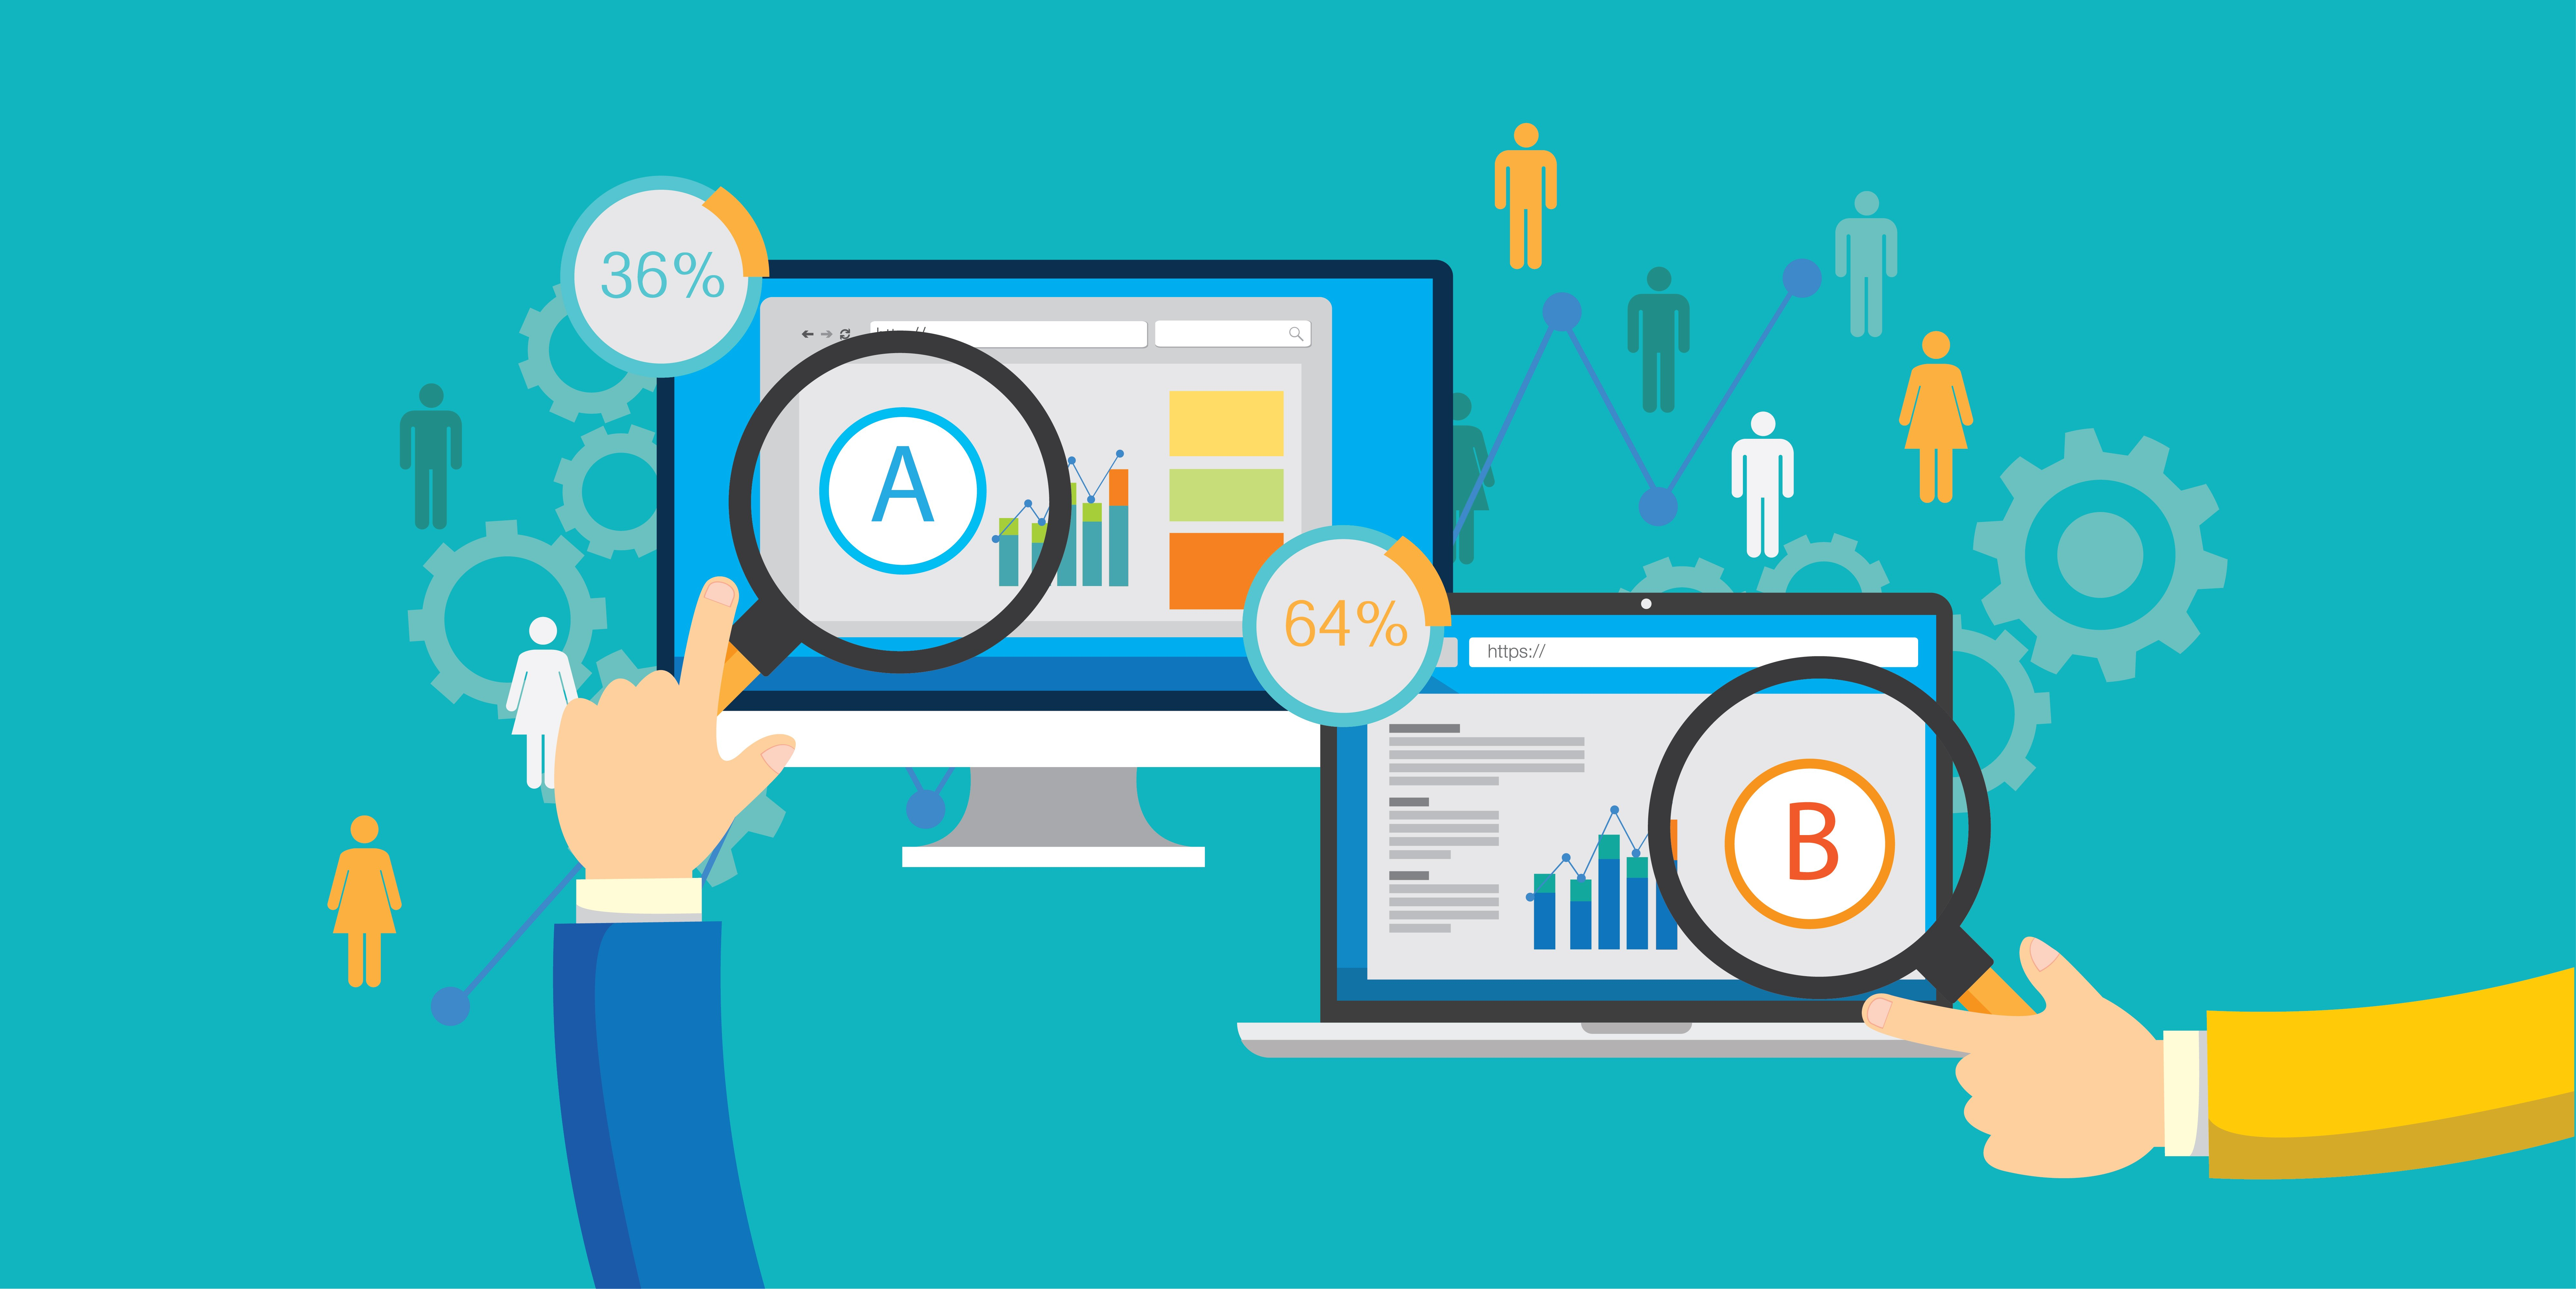

As a Data Scientist at a leading online travel agency, you’ve been tasked with evaluating the impact of a new search ranking algorithm designed to improve conversion rates. The Product team is considering a full rollout, but only if the experiment shows a clear positive effect on the conversion rate and does not lead to a longer time to book.

They have shared A/B test datasets with session-level booking data (`"sessions_data.csv"`) and user-level control/variant split (`"users_data.csv"`). Your job is to analyze and interpret the results to determine whether the new ranking system delivers a statistically significant improvement and provide a clear, data-driven recommendation.

## `sessions_data.csv`

| column | data type | description | 
|--------|-----------|-------------|
| `session_id` | `string` | Unique session identifier (unique for each row) |
| `user_id` | `string` | Unique user identifier (non logged-in users have missing user_id values; each user can have multiple sessions) |
| `session_start_timestamp` | `string` | When a session started |
| `booking_timestamp` | `string` | When a booking was made (missing if no booking was made during a session) |
| `time_to_booking` | `float` | time from start of the session to booking, in minutes (missing if no booking was made during a session) |
| `conversion` | `integer` | _New column to create:_ did session end up with a booking (0 if booking_timestamp or time_to_booking is Null, otherwise 1) |

<br>

## `users_data.csv`

| column | data type | description | 
|--------|-----------|-------------|
| `user_id` | `string` | Unique user identifier (only logged-in users in this table) |
| `experiment_group` | `string` | control / variant split for the experiment (expected to be equal 50/50) |

<br>

The full on criteria are the following:
- Primary metric (conversion) effect must be statistically significant and show positive effect (increase).
- Guardrail (time_to_booking) effect must either be statistically insignificant or show positive effect (decrease)

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import chisquare
from pingouin import ttest
from statsmodels.stats.proportion import proportions_ztest

In [2]:
sessions = pd.read_csv('sessions_data.csv')
users = pd.read_csv('users_data.csv')

In [4]:
sessions.sample(5)

,session_id,user_id,session_start_timestamp,booking_timestamp,time_to_booking
15263,vvswMYmjf0kBIbl1,gSD6qqQUYJHbuESP,2025-01-15 02:15:17.778616428,NaN,NaN
586,G7eK3zZBT9K9ASsY,NaN,2025-01-06 18:38:14.336928368,2025-01-06 18:46:33.123602201,8.313111
9789,rugrLMfVZ2ZCYI0p,DXPY3KHgfwM9YE2v,2025-01-15 06:47:37.120049477,NaN,NaN
3607,movOpcoyU3ZyUGy5,lHSZFwfaUIIyHUKz,2025-01-15 15:42:44.861703634,NaN,NaN
3044,4ZY0VjFMa3rwYLuD,6UAYaDjEHkb3mF32,2025-01-30 13:02:57.052223682,NaN,NaN


In [3]:
users.sample(5)

,user_id,experiment_group
4919,ZM5TVe8tJRhUwreS,variant
832,bmhpRcsAOMV2hSC9,control
8579,Ak7xdOfaAaJnnQta,variant
5402,49tlQFDyLu2BAMYB,control
3272,1ChIglScLPXMAXGU,variant


### Your solution

In [4]:
confidence_level = 0.90  # Set the pre-defined confidence level (90%)
alpha = 1 - confidence_level  # Significance level for hypothesis tests

In [7]:
# Start here, using as many cells as you require

In [9]:
sessions_x_users=sessions.merge(users,how='inner',on='user_id')
sessions_x_users['conversion']=np.where(sessions_x_users['booking_timestamp'].isna(),0,1)


In [13]:
sessions_x_users.sample(7)

,session_id,user_id,session_start_timestamp,booking_timestamp,time_to_booking,experiment_group,conversion
12737,QNPeeq7RJcger8a8,BF0YswkBPaHKJfKY,2025-01-23 03:58:16.542284489,2025-01-23 04:11:49.967774177,13.557091,variant,1
13303,tP04xmKdeC3FnEFw,H9gJUEZhwq4yujhY,2025-01-01 04:07:45.065179825,NaN,NaN,control,0
369,ab8yg4lZjApDCU25,wAmB5ADbDc2vCnSo,2025-01-16 21:28:44.747642756,NaN,NaN,variant,0
2246,z6TGEGlwgfWJSMOR,kQVvFDaCRHydTJjx,2025-01-21 16:48:56.329585552,NaN,NaN,variant,0
10761,1QcMAS2iUa0As80p,YaVEzSo6V5uBuROs,2025-01-17 16:20:10.392901182,2025-01-17 16:38:10.266259866,17.997889,variant,1
12453,vjmfbba1x0Yy6q3u,q3dyoVfKaTkJYgyg,2025-01-19 20:41:35.164509773,2025-01-19 20:54:13.626094905,12.641026,variant,1
4828,cnQUzqGwR4klaAut,VdQMHr38XIsnWx72,2025-01-29 13:31:46.966107607,NaN,NaN,variant,0


In [14]:
sessions_x_users.shape

(15283, 7)

# Sanity Check

In [17]:
control_users=sessions_x_users[sessions_x_users['experiment_group']=='control']['user_id'].nunique()
variant_users=sessions_x_users[sessions_x_users['experiment_group']=='variant']['user_id'].nunique()
total_users=control_users+variant_users
print('Number of users in control group = ', control_users)
print('Number of users in variant group = ', variant_users)
print('Number of total users = ', total_users)

Number of users in control group =  4706
Number of users in variant group =  4748
Number of total users =  9454


In [20]:
control_users_percentage=control_users/total_users
variant_users_percentage=variant_users/total_users
print('Percentage of users in control group = ', round(control_users_percentage,4)*100)
print('Percentage of users in variant group = ', round(variant_users_percentage,4)*100)

Percentage of users in control group =  49.78
Percentage of users in variant group =  50.22


- Ho: SRM likely not present  
- H1: SRM likely present  
- Condition : if p_value < alpha Then we reject Ho (SRM likely present)

In [22]:
observed=[control_users,variant_users]
expected=[total_users/2,total_users/2]
from scipy.stats import chisquare
statistic,srm_chi2_pval=chisquare(observed,f_exp=expected)
if srm_chi2_pval<alpha:
    print('SRM may likely present')
else:
    print('SRM likely not present')

SRM likely not present


# Function to Calculate Effect size for (Primary Metric and Guradrail Metric)

In [24]:
def effect_size(df:pd.DataFrame,metric:str)->float:
    avg_metric_per_group=df.groupby('experiment_group')[metric].mean()
    effect_size=(avg_metric_per_group['variant']/avg_metric_per_group['control'])-1
    return effect_size

# EFFECT ANALYSIS - Primary METRIC (Conversion)

### Run Z-test for proportions of Primary Metric (conversion)

In [30]:
from statsmodels.stats.proportion import proportions_ztest

#### Conditions:
- Ho: d= Pa-Pb= 0 (Two proportions are equal)
- H1: d= Pa-Pb!= 0 (Two proportions are not equal)

In [36]:
sample_sizes=sessions_x_users['experiment_group'].value_counts().loc[['control','variant']]
success_counts=sessions_x_users.groupby('experiment_group')['conversion'].sum().loc[['control','variant']]
z_statistic_conversion,p_value_conversion=proportions_ztest(success_counts,
                                                           sample_sizes,
                                                           alternative='two-sided')
p_value_conversion=round(p_value_conversion,3)
print('p_value for conversion  =',p_value_conversion)

p_value for conversion  = 0.0


### Calculate Effect Size for Primary Metric (Conversion):

In [39]:
effect_size_conversion=effect_size(sessions_x_users,'conversion')
print('percenrage of inceresing effect for conversion = ',round(effect_size_conversion,3)*100,'%')

percenrage of inceresing effect for conversion =  14.2 %


# EFFECT ANALYSIS - GUARDRAIL METRIC(Time to booking)

### Apply T-test on GUARDRAIL Meric (Time to booking)

In [41]:
from  pingouin import ttest

In [42]:
stats_booking_time=ttest(
    sessions_x_users.loc[(sessions_x_users['experiment_group']=='control'),'time_to_booking'],
    sessions_x_users.loc[(sessions_x_users['experiment_group']=='variant'),'time_to_booking'],
    alternative='two-sided'
)
stats_booking_time

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.618198,2575.103104,two-sided,0.5365,"[-0.26, 0.49]",0.024224,0.053,0.094593


In [51]:
p_value_time_booking=stats_booking_time['p-val'].values[0]
t_stats_time_booking=stats_booking_time['T'].values[0]
print('p_value for booking time ',round(p_value_time_booking,3))


p_value for booking time  0.536


### Calculate Effect Size for Guardrail Metric (Booking Time):

In [58]:
effect_size_booking_time=effect_size(sessions_x_users,'time_to_booking')
print('percenrage effect for time to booking = ',round(effect_size_booking_time,3)*100,'%')

percenrage effect for time to booking =  -0.8 %


- booking to time reduce for variant group by small percentage (0.8 %) but this is good news for guardrail metric

# Decision

In [65]:
# primary metric(Conversion Rate ) must be statistically significant and show positive effect(must increase)
creteria_on_conversion = (p_value_conversion < alpha) & (effect_size_conversion > 0)
# Guardrail metric(booking to time ) must be statistically significant or show positive effect(must decrease)
creteria_on_booking_time = (p_value_time_booking < alpha) | (effect_size_booking_time < 0)
if creteria_on_conversion and creteria_on_booking_time:
    print('The experiment results are significantly positive for primary metric (Conversion Rate) and\n'
          'the Guardrail metric (time to booking) wasn\'t harmed so we are going full on.')
else:
    print('The experiment results aren\'t significantly positive for primary metric (Conversion Rate) or\n'
          'the Guardrail metric (time to booking) was harmed so we are pulling back')

The experiment results are significantly positive for primary metric (Conversion Rate) and
the Guardrail metric (time to booking) wasn't harmed so we are going full on.
